# Task 5.

### CNN Task: Multi-Tank Classification

### Objective
Develop a Convolutional Neural Network (CNN) to classify images of military tanks using the "Military Tanks Dataset Images" from Kaggle.

## Steps

1. **Data Acquisition**
   - Import necessary libraries (Torch or TensorFlow/Keras, pandas, numpy, etc.).
   - Load the dataset: `tank_images = 'path_to_dataset_directory'`.

2. **Data Preprocessing**
   - Perform image preprocessing (resizing, normalization).
   - Split the dataset into training, validation, and testing sets.

3. **CNN Model Development**
   - Define a CNN model architecture using Torch or Keras.
   - Consider using data augmentation techniques.

4. **Training the Model**
   - Compile the CNN model.
   - Train the model on the training dataset.
   - Use validation data to tune hyperparameters.

5. **Model Evaluation**
   - Evaluate the model's performance on the test set.
   - Analyze the classification accuracy and loss.

6. **Fine-Tuning and Optimization**
   - Adjust model architecture and parameters for better performance.
   - Re-train and evaluate the model.

7. **Conclusion**
   - Summarize the model's performance.
   - Suggest potential improvements or further research areas.

## Dataset
Download from: [Kaggle - Military Tanks Dataset Images](https://www.kaggle.com/datasets/antoreepjana/military-tanks-dataset-images)


In [73]:
# Imports
import os
import pathlib
import logging
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics
from torchinfo import summary
from tqdm import tqdm

In [3]:
# Logs
logging.basicConfig(level=logging.INFO)
logging.basicConfig(format="%(asctime)s - %(levelname)s - %(messages)s")
logging.basicConfig(filename="logs/hw5_logs.log", level=logging.INFO)

In [127]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Our datasets doesn't have train and test split

In [4]:
# Set path to our data
data = pathlib.Path('data/')
tank_data_path = data / "tank_images/"

In [5]:
# Take a look at our data folder and number of images in it
number_of_files = 0
for (roots, _, files) in os.walk(tank_data_path):
    print(roots, "Num of files in directory: ", len(files))
    number_of_files+=len(files)
print("\nTotal num of imgs: ", number_of_files)

print("\nAverage number of images in a folder: ", number_of_files/(len(list(os.walk(tank_data_path)))-1))

data\tank_images Num of files in directory:  0
data\tank_images\test Num of files in directory:  0
data\tank_images\train Num of files in directory:  0

Total num of imgs:  0

Average number of images in a folder:  0.0


In [6]:
for (roots, _, files) in os.walk(tank_data_path):
    print(roots, files)

data\tank_images []
data\tank_images\test []
data\tank_images\train []


In [34]:
# Restart
shutil.rmtree(tank_data_path)

# Create a proper structure for ImageFolder datasets
test_split = 0.2
name_index = 17

# Unzip tank_imgs archive
with zipfile.ZipFile('data/tank_imgs.zip', 'r') as f:
    f.extractall(path=data)

# Creating train and test folders if such don't exist
train_tank_dir = pathlib.Path("data/tank_images/train")
test_tank_dir = pathlib.Path("data/tank_images/test")
if not train_tank_dir.is_dir():
    train_tank_dir.mkdir()
if not test_tank_dir.is_dir():
    test_tank_dir.mkdir()

# Iter through dirs with tank imgs and move them to train and test folders  
for (roots, dirs, files) in os.walk(tank_data_path):
    train_im_num = len(files) - int(test_split*len(files)) # Counts 80% of images in folder for training
    # Splits !dirs! in train/test (This block will run ones!)
    for dir in dirs:
        if dir in ["train", "test"]:
            continue
        if not (train_tank_dir/dir).is_dir():
            (train_tank_dir/dir).mkdir()
        if not (test_tank_dir/dir).is_dir():
            (test_tank_dir/dir).mkdir()
    # Split !images! into train/test
    for i, file in enumerate(files, start=1):
        parents = [train_tank_dir, test_tank_dir]
        root = pathlib.Path(roots)
        if root.parent in parents:
            continue
        if i < train_im_num:
            file_a = pathlib.Path(f'{roots}\\{file}')
            file_b = train_tank_dir / f'{roots[name_index:]}\\{file}'
            file_a.rename(file_b)
        else:
            file_a = pathlib.Path(f'{roots}\\{file}')
            file_b = test_tank_dir / f'{roots[name_index:]}\\{file}'
            file_a.rename(file_b)
            
# Cleanup (delete all spare folders)
for (roots, dirs, files) in os.walk(tank_data_path):
    root = pathlib.Path(roots)
    for dir in dirs:
        if ((train_tank_dir != (root/dir).parent and test_tank_dir != (root/dir).parent) and ((root/dir) not in [train_tank_dir, test_tank_dir])) or len(os.listdir(root/dir))==0:
            shutil.rmtree(root / dir)

In [57]:
number_of_classes = len(os.listdir(test_tank_dir))

In [110]:
# Transformers
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

# Hyperparameters for loaders
BATCHSIZE = 32
NUM_WORKERS = os.cpu_count()

# Datasets
raw_tank_dataset = ImageFolder(train_tank_dir)
train_dataset = ImageFolder(train_tank_dir, transform=transform)
test_dataset = ImageFolder(test_tank_dir, transform=transform)

# Labels
class_names = train_dataset.classes

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers=NUM_WORKERS)

In [111]:
train_dataset[0][0]

tensor([[[0.9725, 0.9725, 0.9686,  ..., 0.9608, 0.9647, 0.9608],
         [0.9765, 0.9765, 0.9725,  ..., 0.9647, 0.9647, 0.9608],
         [0.9804, 0.9765, 0.9765,  ..., 0.9647, 0.9647, 0.9608],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.7686, 0.8157, 0.8902],
         [1.0000, 1.0000, 1.0000,  ..., 0.6980, 0.8000, 0.9098],
         [1.0000, 1.0000, 1.0000,  ..., 0.9529, 0.9569, 0.9412]],

        [[0.9725, 0.9765, 0.9725,  ..., 0.9647, 0.9647, 0.9647],
         [0.9804, 0.9765, 0.9725,  ..., 0.9647, 0.9647, 0.9647],
         [0.9843, 0.9804, 0.9765,  ..., 0.9686, 0.9647, 0.9647],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.7294, 0.7725, 0.8392],
         [0.9961, 0.9961, 0.9961,  ..., 0.6745, 0.7647, 0.8627],
         [0.9961, 0.9961, 0.9961,  ..., 0.9451, 0.9451, 0.9098]],

        [[0.9255, 0.9255, 0.9216,  ..., 0.9255, 0.9255, 0.9216],
         [0.9255, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9216],
         [0.9255, 0.9255, 0.9294,  ..., 0.9255, 0.9255, 0.

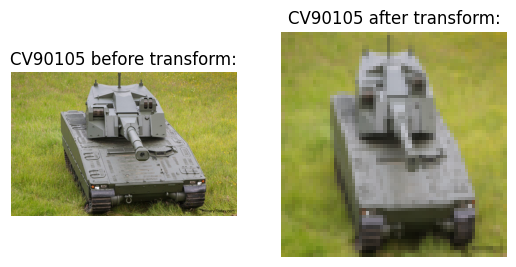

In [126]:
# Visualize images
im_num = random.choice(range(len(class_names)))
raw_sample = raw_tank_dataset[im_num][0]
sample = train_dataset[im_num][0]
im_label = train_dataset[im_num][1]
plt.subplot(1, 2, 1)
plt.title(f'{class_names[im_label].upper()} before transform:')
plt.axis(False)
plt.imshow(raw_sample);
plt.subplot(1, 2, 2)
plt.title(f'{class_names[im_label].upper()} after transform:')
plt.axis(False)
plt.imshow((sample).permute(1,2,0).numpy());

In [144]:
# Create a NN
class TankFinderModel_V0(nn.Module):
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.conv_layer_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes, out_channels=hidden_nodes, stride=1, padding=0, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(stride=1, padding=0, kernel_size=3)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=0, out_features=64),
            nn.Linear(in_features=64, out_features=output_nodes),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))
        

In [145]:
model_V0 = TankFinderModel_V0(input_nodes=3, hidden_nodes=32, output_nodes=number_of_classes).to(device=device)

c:\Users\Sanya\kapitonnov_nn_n00b\neural_n00b\nn_n00b_env\Lib\site-packages\torch\nn\init.py:412: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [139]:
model_V0

TankFinderModel_V0(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=150, bias=True)
    (3): Softmax(dim=None)
  )
)

In [140]:
summary(model_V0)

Layer (type:depth-idx)                   Param #
TankFinderModel_V0                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       9,248
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       9,248
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       9,248
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      346,176
│    └─Linear: 2-13                      9,750
│    └─Softmax: 2-14                     --
Total params: 384,566
Trainable params: 384,566
Non-trainable params: 0

In [141]:
# Accuracy function
def accuracy_fn(y_preds, y_true):
    """Returns a percentage of correct predictions to all predictions"""
    correct = np.array(y_true) == np.array(y_preds)
    res = correct.sum() / len(np.array(y_true))
    return res*100

In [142]:
# Functionize our code a bit

# Setup options
EPOCHS = 10
LR = 0.01
loss_func = nn.CrossEntropyLoss
acc_func = accuracy_fn
optim = torch.optim.Adam(params=model_V0.parameters(), lr=LR)

# Training func
def train_step(model, dataloader, loss_fn, acc_fn, optimizer, device, epoch):
    model.train()
    mean_loss, mean_acc = 0, 0
    progress_bar = tqdm(
      enumerate(dataloader, start=1), 
      desc=f"Training Epoch {epoch}", 
      total=len(dataloader)
      )
    for batch, (X, y) in progress_bar:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = loss_fn(logits, y)
        acc = acc_fn(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        logging.info(f'Train Loss: {loss} || Train accuracy: {acc} Batch №: {batch}')
        mean_loss += loss
        mean_acc += acc
    mean_loss /= batch
    mean_acc /= batch
    logging.info(f'Mean Train Loss: {mean_loss} || Mean Train acc: {mean_acc}')
    return mean_loss, mean_loss
    
# Testing func
def test_step(model, dataloader, loss_fn, acc_fn, device, epoch):
    model.eval()
    progress_bar = tqdm(
      enumerate(dataloader, start=1), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader)
      )
    with torch.no_grad():
        for batch, (X, y) in progress_bar:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            acc = acc_fn(preds, y)
            logging.info(f'Test Loss: {loss} || Test accuracy: {acc} Batch №: {batch}')
            mean_loss += loss
            mean_acc += acc
    mean_loss /= batch
    mean_acc /= batch
    logging.info(f'Mean Train Loss: {mean_loss} || Mean Train acc: {mean_acc}')
    return mean_loss, mean_loss

# Training loop
def train(model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, device, epochs):
    for epoch in range(epochs):
        train_step(model, train_dataloader, loss_fn, acc_fn, optimizer, device, epoch)
        test_step(model, test_dataloader, loss_fn, acc_fn, device, epoch)

In [146]:
train(model=model_V0, 
      train_dataloader=train_dataloader, 
      test_dataloader=test_dataloader,
      loss_fn=loss_func,
      acc_fn=acc_func,
      optimizer=optim,
      device=device,
      epochs=EPOCHS)

Training Epoch 0:   0%|          | 0/24 [00:16<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x86528 and 0x64)